# Pizza vs Not Pizza Binary Image Classification

## Description

- Simple Task: Is this picture a Pizza or not?
- Source from Kaggle: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza/data
- Subset of the Food101 Dataset: Food-101 – Mining Discriminative Components with Random Forests.
- We used the notebook from the lecture as a guide and added our own ideas to it. (https://lectures.mi.hdm-stuttgart.de/mi7sltai/)


### Dataset:
(Quick look when we download the raw files from Kaggle)

In [1]:
import os #operating system library 

In [2]:
#raw images when downloaded
pizza_folder = os.listdir('../pizza_not_pizza/pizza')
not_pizza_folder = os.listdir('../pizza_not_pizza/not_pizza')

print('Pizza Images:', len(pizza_folder), 'Not Pizza Images:', len(not_pizza_folder))

Pizza Images: 983 Not Pizza Images: 983


### Example:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

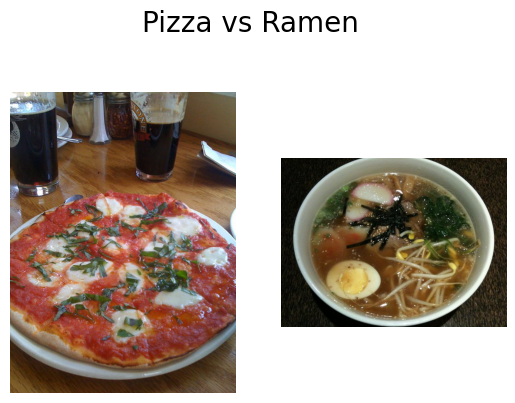

In [4]:
pizza = mpimg.imread('../pizza_not_pizza/pizza/2965.jpg')
not_pizza = mpimg.imread('../pizza_not_pizza/not_pizza/23747.jpg')

plt.subplot(1, 2, 1)
plt.imshow(pizza)
plt.axis('off') 
plt.subplot(1, 2, 2)
plt.imshow(not_pizza)
plt.axis('off')
plt.suptitle('Pizza vs Ramen', fontsize=20)
plt.show()

### Beginning Questions/ Thoughts

- Are ~1000 images for each class enough? What influence does data augmentation have on accuracy?
- Images don't have the same size and are not split in training/validation/test
- How does a CNN perform vs a simple MLP?
- How does different hyperparameters influence the performance of the model?

Bonus Question: Is the pizza from the Uni Mensa Stuttgart a pizza according to the model?

We try to answer these questions in our presentation..

## Structure 

1. Data preparation 
2. Simple MLP 
3. CNN
4. Prevent Overfitting?
5. Conclusion

So let's begin!

## 1. Data preparation

### 1.1 Split into training, validation and test

In [5]:
!pwd

/home/nick/Desktop/sltai/exercise/src


In [6]:
# show the image directory
image_path = '../pizza_not_pizza'
os.listdir(image_path)

['not_pizza', 'pizza']

In [7]:
# list of first pizzas
pizza_path = '../pizza_not_pizza/pizza'
os.listdir(pizza_path)[:5]

['370643.jpg', '3798959.jpg', '3663580.jpg', '2952219.jpg', '3337370.jpg']

Split the dataset in train, valid and test folders.
Most common strategy is 80/10/10, we try this.
https://www.v7labs.com/blog/train-validation-test-set

In [8]:
# shutil for copying the files into a seperate folder, random to shuffle the files
import shutil
import random

def split_dataset(input_folder, output_folder, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1):
    
    #iterate over the pizza and not pizza folder
    for class_folder in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_folder)
        if os.path.isdir(class_path):
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(files)

            train_split = int(train_ratio * len(files))
            validation_split = int((train_ratio + validation_ratio) * len(files))
            
            #first 80% for training files, 10% for validation and 10% for testing
            train_files = files[:train_split]
            validation_files = files[train_split:validation_split]
            test_files = files[validation_split:]

            for split, split_name in zip([train_files, validation_files, test_files], ['train', 'validation', 'test']):
                output_split_folder = os.path.join(output_folder, split_name, class_folder)
                os.makedirs(output_split_folder, exist_ok=True)

                for file_name in split:
                    source_path = os.path.join(class_path, file_name)
                    destination_path = os.path.join(output_split_folder, file_name)
                    shutil.copyfile(source_path, destination_path)


input_folder = '../pizza_not_pizza'
output_folder = '../images'

split_dataset(input_folder, output_folder)

In [9]:
# let's look at the folder structure of the generated image folder
new_image_path = '../images'
print('Image Folder:', os.listdir(new_image_path))
print('Training Folder:',os.listdir(new_image_path+'/train'))
print('Image File:',os.listdir(new_image_path+'/train/pizza')[:1])

Image Folder: ['validation', 'train', 'test']
Training Folder: ['not_pizza', 'pizza']
Image File: ['370643.jpg']


Now we have the desired structure. Our next step will be to create the torch data set. 

### 1.2 Create Dataset

We first use the transforms module to define the transformations and augmentation. To get an answer to our question, we first define a simple transforms module and then a more complex one with augmentation.(https://pytorch.org/vision/stable/transforms.html).

In [10]:
from torchvision import datasets, transforms, utils

In [11]:
# only using the basic transformations
# the ToSensor() is only scaling, not normalizing
simple_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

In [12]:
#additional augmentation
#https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html
additional_transforms= {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomVerticalFlip(0.2),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(degrees=20),
        transforms.RandomPerspective(distortion_scale=0.2,p=0.2),
        transforms.GaussianBlur(5,9), #kernel size
        transforms.ToTensor() 
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

Now we are creating 2 datasets. One simple and one more advanced with augmentations. 

In [13]:
simple_dataset = {x: datasets.ImageFolder(os.path.join(new_image_path,x),
                  transform=simple_transforms[x])
                  for x in ['train', 'validation', 'test']}

In [14]:
advanced_dataset = {x: datasets.ImageFolder(os.path.join(new_image_path,x),
                  transform=additional_transforms[x])
                  for x in ['train', 'validation', 'test']}

Let's look at some information on the datasets.

In [15]:
advanced_dataset['train'].classes

['not_pizza', 'pizza']

In [16]:
print(advanced_dataset['train'].targets[:50])
print(advanced_dataset['train'].targets[800:850])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The dataset is not shuffled yet, the Dataloader does this later on.

In [17]:
image, label =advanced_dataset['train'][20]

In [18]:
print(label)
print(image.shape)

0
torch.Size([3, 224, 224])


To show the image with pyplot we need to swap the dimensions with permute. 

In [19]:
plt_image = image.permute(1, 2, 0).numpy()
plt_image.shape

(224, 224, 3)

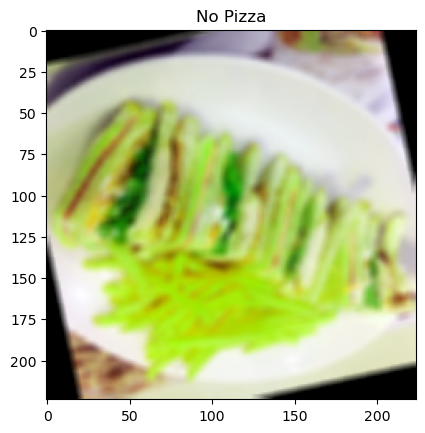

In [20]:
plt.imshow(plt_image)
plt.title('No Pizza' if advanced_dataset['train'].targets[20]==0 else 'Pizza')
plt.show()

### 1.3 Create Dataloaders

No we are create 6 Dataloaders. 3 for the simple dataset for train, validation and test. And 3 for the advanced dataset. They are being used to preprocess data for an efficient way to train model on a large dataset.

In [21]:
from torch.utils.data import DataLoader

In [22]:
batchsize = 16 # batch size of 4 achieved no good results

In [23]:
#we are using the batch size 16 and we need to shuffle the data  
simple_dataloaders = {x: DataLoader(simple_dataset[x], batch_size=batchsize,
                             shuffle=True)
              for x in ['train', 'validation', 'test']}

In [24]:
advanced_dataloaders = {x: DataLoader(advanced_dataset[x], batch_size=batchsize,
                             shuffle=True)
              for x in ['train', 'validation', 'test']}

Let's show the first image batches.

In [25]:
import numpy as np

In [26]:
simple_train_imagebatch = next(iter(simple_dataloaders['train']))
advanced_train_imagebatch=next(iter(advanced_dataloaders['train']))

In [27]:
#show image batches
#the function from https://lectures.mi.hdm-stuttgart.de/mi7sltai/03_cifar10_classification_mlp_cnn.html
def my_imshow(img):
    plt.figure(figsize=(12,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

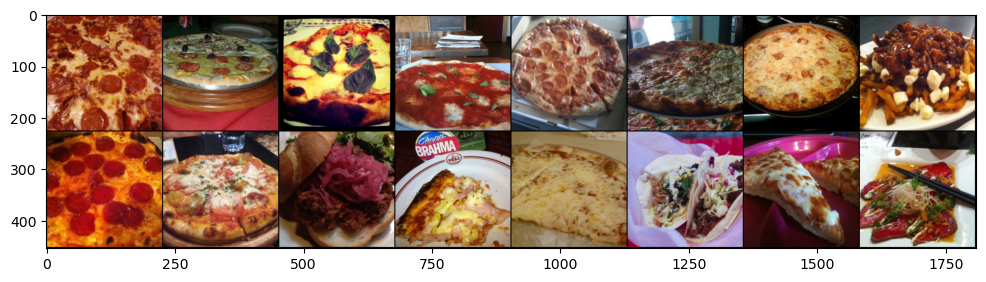

In [28]:
my_imshow(utils.make_grid(simple_train_imagebatch[0]))

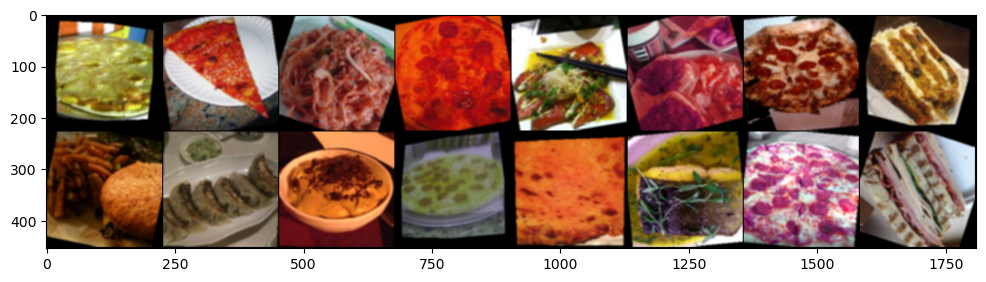

In [29]:
my_imshow(utils.make_grid(advanced_train_imagebatch[0]))

## 2. Simple MLP

To compare the result with a CNN later, we create a simple MLP.

Firstly we create a function which we can use later to train our models. We use the accuracy module of sklearn which takes the correct labels and the predicted labels as parameters. Reminder: For binary classification the accuracy is measured as follows. 

(TP+TN)/(TP+TN+FP+FN)

In [30]:
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn

In [31]:
def train_model(learning_rate, num_epochs, dataloader, model):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    #combines a Sigmoid layer and the BCELoss in one single class
    #https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
    #-> Sigmoid maps output between 0 and 1
    #->binary cross entropy loss function
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #achieving better results then sgd
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        predictions_list = []
        labels_list = []
        
        #training phase
        for i, (images, labels) in enumerate(dataloader['train']):
            model.train() #training mode
            images = images.to(device)
            labels = labels.to(device)

            # Forward + Backward + Loss
            predictions = model(images)
            #add extra dimension to fit predictions
            labels = labels.view(-1, 1).float()
            loss = criterion(predictions, labels)
            optimizer.zero_grad() #reset gradients
            loss.backward() #gradients off the loss in respect to paramets
            optimizer.step() #parameter update 

            running_loss += loss.item()

            # Collect predictions and labels for accuracy calculation
            predictions_list.extend((predictions > 0.5).float().cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
        # Calculate and print the accuracy after each epoch
        accuracy = accuracy_score(labels_list, predictions_list)
        average_loss = running_loss / len(dataloader['train'])
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')
        
        # Validation Phase
        model.eval() #f.E. with dropout layers, all units are used
        val_predictions_list = []
        val_labels_list = []

        for i, (val_images, val_labels) in enumerate(dataloader['validation']):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_predictions = model(val_images)
            val_labels = val_labels.view(-1, 1).float()

            # Collect predictions and labels for accuracy calculation
            val_predictions_list.extend((val_predictions > 0.5).float().cpu().numpy())
            val_labels_list.extend(val_labels.cpu().numpy())

        # Calculate and print the validation accuracy after each epoch
        val_accuracy = accuracy_score(val_labels_list, val_predictions_list)
        print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Accuracy: {val_accuracy:.4f}')
        print('---------------------------------------------------------------------------')

Now we can create a simple MLP to train our first model.

In [32]:
#MLP Architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.d1 = nn.Linear(3 * 224 * 224, 512)
        self.hidden = nn.Linear(512, 256) 
        self.d2 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.d1(x)
        x = nn.functional.relu(x)
        x = self.hidden(x)
        x = nn.functional.relu(x)
        logits = self.d2(x)
        return logits

In [33]:
from torchsummary import summary

In [34]:
mlp_model = MLP()
summary(mlp_model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]      77,070,848
            Linear-2                  [-1, 256]         131,328
            Linear-3                    [-1, 1]             257
Total params: 77,202,433
Trainable params: 77,202,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.01
Params size (MB): 294.50
Estimated Total Size (MB): 295.08
----------------------------------------------------------------


### Disclaimer:
These are just our guesses and hypotheses that we noticed during training.  

In [38]:
train_model(0.0001,15,simple_dataloaders,mlp_model)

Training - Epoch [1/15], Loss: 0.7292, Accuracy: 0.5776
Validation - Epoch [1/15], Accuracy: 0.6173
---------------------------------------------------------------------------
Training - Epoch [2/15], Loss: 0.6165, Accuracy: 0.6399
Validation - Epoch [2/15], Accuracy: 0.6224
---------------------------------------------------------------------------
Training - Epoch [3/15], Loss: 0.6055, Accuracy: 0.6552
Validation - Epoch [3/15], Accuracy: 0.7092
---------------------------------------------------------------------------
Training - Epoch [4/15], Loss: 0.5870, Accuracy: 0.6711
Validation - Epoch [4/15], Accuracy: 0.7194
---------------------------------------------------------------------------
Training - Epoch [5/15], Loss: 0.5487, Accuracy: 0.6966
Validation - Epoch [5/15], Accuracy: 0.7347
---------------------------------------------------------------------------
Training - Epoch [6/15], Loss: 0.5504, Accuracy: 0.7074
Validation - Epoch [6/15], Accuracy: 0.6327
--------------------

And for the augmented data:

In [39]:
mlp_model_aug = MLP()
train_model(0.0001,15,advanced_dataloaders,mlp_model_aug)
#school example thesis -> generalizing, model perfoms better on unseen data
#further examples with higher epoch rate


Training - Epoch [1/15], Loss: 0.7307, Accuracy: 0.5916
Validation - Epoch [1/15], Accuracy: 0.6224
---------------------------------------------------------------------------
Training - Epoch [2/15], Loss: 0.6635, Accuracy: 0.6062
Validation - Epoch [2/15], Accuracy: 0.5000
---------------------------------------------------------------------------
Training - Epoch [3/15], Loss: 0.6809, Accuracy: 0.5872
Validation - Epoch [3/15], Accuracy: 0.5918
---------------------------------------------------------------------------
Training - Epoch [4/15], Loss: 0.6504, Accuracy: 0.6011
Validation - Epoch [4/15], Accuracy: 0.6786
---------------------------------------------------------------------------
Training - Epoch [5/15], Loss: 0.6360, Accuracy: 0.6221
Validation - Epoch [5/15], Accuracy: 0.6939
---------------------------------------------------------------------------
Training - Epoch [6/15], Loss: 0.6541, Accuracy: 0.5999
Validation - Epoch [6/15], Accuracy: 0.5102
--------------------

We tried different learning rates. 0.0001 worked for us the best. 

In [43]:
mlp_model_lr = MLP()
train_model(0.001,7,simple_dataloaders,mlp_model_lr) #ping pong effect on higher learning rate? 

Training - Epoch [1/7], Loss: 1.9610, Accuracy: 0.5592
Validation - Epoch [1/7], Accuracy: 0.5051
---------------------------------------------------------------------------
Training - Epoch [2/7], Loss: 0.6795, Accuracy: 0.5973
Validation - Epoch [2/7], Accuracy: 0.7296
---------------------------------------------------------------------------
Training - Epoch [3/7], Loss: 0.6119, Accuracy: 0.6508
Validation - Epoch [3/7], Accuracy: 0.5510
---------------------------------------------------------------------------
Training - Epoch [4/7], Loss: 0.6184, Accuracy: 0.6501
Validation - Epoch [4/7], Accuracy: 0.5714
---------------------------------------------------------------------------
Training - Epoch [5/7], Loss: 0.5924, Accuracy: 0.6533
Validation - Epoch [5/7], Accuracy: 0.5153
---------------------------------------------------------------------------
Training - Epoch [6/7], Loss: 0.5994, Accuracy: 0.6609
Validation - Epoch [6/7], Accuracy: 0.7143
--------------------------------

## 3. CNN

Now we are a testing a CNN. Firstly without a Pooling Layer and only one conv layer. 
Idea from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and
https://www.youtube.com/watch?v=pDdP0TFzsoQ

In [51]:
#CNN Architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(3,3), stride=1, padding=1)
        self.d1 = nn.Linear(224*224*6, 120) # more details on the layer later on
        self.d2 = nn.Linear(120, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = x.flatten(start_dim=1)
        x = self.d1(x)
        x = nn.functional.relu(x)
        logits = self.d2(x)
        return logits

In [52]:
cnn_model = CNN()
summary(cnn_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             168
            Linear-2                  [-1, 120]      36,126,840
            Linear-3                    [-1, 1]             121
Total params: 36,127,129
Trainable params: 36,127,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.30
Params size (MB): 137.81
Estimated Total Size (MB): 140.69
----------------------------------------------------------------


In [53]:
train_model(0.0001, 15, simple_dataloaders, cnn_model)

Training - Epoch [1/15], Loss: 0.7780, Accuracy: 0.6018
Validation - Epoch [1/15], Accuracy: 0.6939
---------------------------------------------------------------------------
Training - Epoch [2/15], Loss: 0.5910, Accuracy: 0.6679
Validation - Epoch [2/15], Accuracy: 0.6429
---------------------------------------------------------------------------
Training - Epoch [3/15], Loss: 0.5612, Accuracy: 0.7048
Validation - Epoch [3/15], Accuracy: 0.6684
---------------------------------------------------------------------------
Training - Epoch [4/15], Loss: 0.5428, Accuracy: 0.7074
Validation - Epoch [4/15], Accuracy: 0.6990
---------------------------------------------------------------------------
Training - Epoch [5/15], Loss: 0.5443, Accuracy: 0.7112
Validation - Epoch [5/15], Accuracy: 0.7041
---------------------------------------------------------------------------
Training - Epoch [6/15], Loss: 0.5104, Accuracy: 0.7398
Validation - Epoch [6/15], Accuracy: 0.6633
--------------------

We didn't get any better results than the simple MLP. So we just jumped right to a more complex version with pooling layer.
What are convolution and pooling layers? 

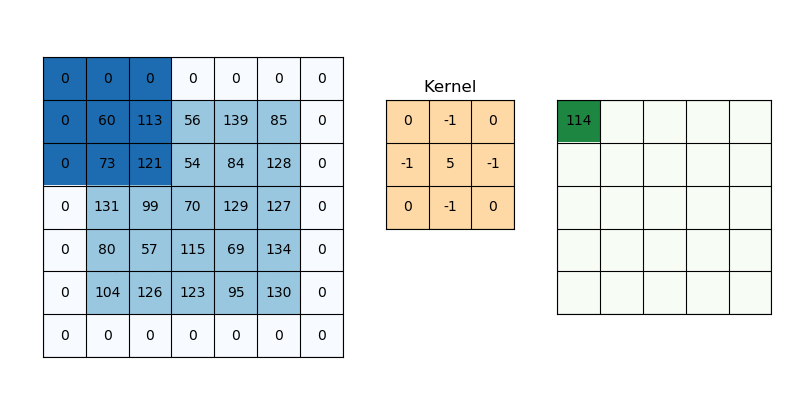

In [39]:
#https://miro.medium.com/v2/resize:fit:875/1*O06nY1U7zoP4vE5AZEnxKA.gif
from IPython.display import display, Image
with open('../convolution.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))

In [84]:
#CNN more complex architecture
class CNN_c(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5), stride=1, padding=1) #size (224-5F+2*1P)/1S +1 = 222
        self.pool = nn.MaxPool2d(2,2) # pooling /2 size=111
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(3,3), stride=1, padding=1) #size (111-3F+2P)/1S +1 = 111
        self.fc1 = nn.Linear(55*55*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        logits = self.fc3(x)
        return logits

In [85]:
cnn_model_complex = CNN_c()
summary(cnn_model_complex, (3,224,224)) #much lower parameter size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 222, 222]             456
         MaxPool2d-2          [-1, 6, 111, 111]               0
            Conv2d-3         [-1, 16, 111, 111]             880
         MaxPool2d-4           [-1, 16, 55, 55]               0
            Linear-5                  [-1, 120]       5,808,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 1]              85
Total params: 5,819,705
Trainable params: 5,819,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.69
Params size (MB): 22.20
Estimated Total Size (MB): 27.47
----------------------------------------------------------------


In [86]:
train_model(0.0001, 15, simple_dataloaders, cnn_model_complex)

Training - Epoch [1/15], Loss: 0.6771, Accuracy: 0.5089
Validation - Epoch [1/15], Accuracy: 0.5255
---------------------------------------------------------------------------
Training - Epoch [2/15], Loss: 0.6267, Accuracy: 0.6272
Validation - Epoch [2/15], Accuracy: 0.6633
---------------------------------------------------------------------------
Training - Epoch [3/15], Loss: 0.6089, Accuracy: 0.6501
Validation - Epoch [3/15], Accuracy: 0.6531
---------------------------------------------------------------------------
Training - Epoch [4/15], Loss: 0.5843, Accuracy: 0.6692
Validation - Epoch [4/15], Accuracy: 0.7092
---------------------------------------------------------------------------
Training - Epoch [5/15], Loss: 0.5693, Accuracy: 0.6883
Validation - Epoch [5/15], Accuracy: 0.7194
---------------------------------------------------------------------------
Training - Epoch [6/15], Loss: 0.5435, Accuracy: 0.7163
Validation - Epoch [6/15], Accuracy: 0.7092
--------------------

In [87]:
cnn_model_complex_aug = CNN_c()
train_model(0.0001, 15, advanced_dataloaders, cnn_model_complex_aug)

Training - Epoch [1/15], Loss: 0.6841, Accuracy: 0.5051
Validation - Epoch [1/15], Accuracy: 0.5102
---------------------------------------------------------------------------
Training - Epoch [2/15], Loss: 0.6501, Accuracy: 0.5642
Validation - Epoch [2/15], Accuracy: 0.5000
---------------------------------------------------------------------------
Training - Epoch [3/15], Loss: 0.6315, Accuracy: 0.6107
Validation - Epoch [3/15], Accuracy: 0.6480
---------------------------------------------------------------------------
Training - Epoch [4/15], Loss: 0.6112, Accuracy: 0.6387
Validation - Epoch [4/15], Accuracy: 0.6327
---------------------------------------------------------------------------
Training - Epoch [5/15], Loss: 0.6073, Accuracy: 0.6463
Validation - Epoch [5/15], Accuracy: 0.5816
---------------------------------------------------------------------------
Training - Epoch [6/15], Loss: 0.5967, Accuracy: 0.6552
Validation - Epoch [6/15], Accuracy: 0.7398
--------------------

## 4. Prevent Overfitting?

Maybe add a dropout Layer. 
-> higher learnrate and maybe a drouput layer?

In [47]:
class CNN_c_d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5), stride=1, padding=1) # size (224-5F+2*1P)/1S +1 = 222
        self.pool = nn.MaxPool2d(2, 2) # pooling /2 size=111
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(3,3), stride=1, padding=1) # size (111-3F+2P)/1S +1 = 111
        self.fc1 = nn.Linear(55*55*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer with 50% dropout probability
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)  
        logits = self.fc3(x)
        return logits

In [89]:
cnn_model_complex_d = CNN_c_d()
summary(cnn_model_complex_d, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 222, 222]             456
         MaxPool2d-2          [-1, 6, 111, 111]               0
            Conv2d-3         [-1, 16, 111, 111]             880
         MaxPool2d-4           [-1, 16, 55, 55]               0
            Linear-5                  [-1, 120]       5,808,120
            Linear-6                   [-1, 84]          10,164
           Dropout-7                   [-1, 84]               0
            Linear-8                    [-1, 1]              85
Total params: 5,819,705
Trainable params: 5,819,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.70
Params size (MB): 22.20
Estimated Total Size (MB): 27.47
----------------------------------------------------------------


In [91]:
train_model(0.0001, 20, simple_dataloaders, cnn_model_complex_d)

Training - Epoch [1/20], Loss: 0.2270, Accuracy: 0.9160
Validation - Epoch [1/20], Accuracy: 0.7959
---------------------------------------------------------------------------
Training - Epoch [2/20], Loss: 0.2013, Accuracy: 0.9288
Validation - Epoch [2/20], Accuracy: 0.7857
---------------------------------------------------------------------------
Training - Epoch [3/20], Loss: 0.1666, Accuracy: 0.9504
Validation - Epoch [3/20], Accuracy: 0.7857
---------------------------------------------------------------------------
Training - Epoch [4/20], Loss: 0.1549, Accuracy: 0.9548
Validation - Epoch [4/20], Accuracy: 0.8061
---------------------------------------------------------------------------
Training - Epoch [5/20], Loss: 0.1410, Accuracy: 0.9587
Validation - Epoch [5/20], Accuracy: 0.8163
---------------------------------------------------------------------------
Training - Epoch [6/20], Loss: 0.1210, Accuracy: 0.9656
Validation - Epoch [6/20], Accuracy: 0.7704
--------------------

In [93]:
cnn_model_complex_d_aug = CNN_c_d()
train_model(0.0001, 30, advanced_dataloaders, cnn_model_complex_d_aug)

Training - Epoch [1/30], Loss: 0.6945, Accuracy: 0.5000
Validation - Epoch [1/30], Accuracy: 0.5000
---------------------------------------------------------------------------
Training - Epoch [2/30], Loss: 0.6712, Accuracy: 0.5006
Validation - Epoch [2/30], Accuracy: 0.5000
---------------------------------------------------------------------------
Training - Epoch [3/30], Loss: 0.6580, Accuracy: 0.5172
Validation - Epoch [3/30], Accuracy: 0.5204
---------------------------------------------------------------------------
Training - Epoch [4/30], Loss: 0.6448, Accuracy: 0.5426
Validation - Epoch [4/30], Accuracy: 0.5153
---------------------------------------------------------------------------
Training - Epoch [5/30], Loss: 0.6328, Accuracy: 0.5929
Validation - Epoch [5/30], Accuracy: 0.6378
---------------------------------------------------------------------------
Training - Epoch [6/30], Loss: 0.6159, Accuracy: 0.6247
Validation - Epoch [6/30], Accuracy: 0.7092
--------------------

Let's store the models.

In [95]:
path_1 = './cnn_model_complex_d.pth'
path_2 = './cnn_model_complex_d_aug.pth'
torch.save(cnn_model_complex_d.state_dict(), path_1)
torch.save(cnn_model_complex_d_aug.state_dict(), path_2)

## 5. Conclusion

Test the models on the test data, and the Uni Mensa picture

In [102]:
images,labels = next(iter(simple_dataloaders['test']))

In [103]:
cnn = CNN_c_d()
cnn.load_state_dict(torch.load('cnn_model_complex_d.pth'))
cnn.eval()

CNN_c_d(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=48400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

Why is it giving me not an output between 0 and 1?

In [104]:
outputs = cnn(images)
outputs

tensor([[ -8.2243],
        [  4.4796],
        [ -6.0893],
        [ -8.4853],
        [  8.3673],
        [ -5.6859],
        [  5.7187],
        [  5.0086],
        [  7.8078],
        [ -4.2457],
        [  7.0503],
        [  2.2550],
        [  1.5716],
        [-11.3352],
        [ -8.6636],
        [ -9.6826]], grad_fn=<AddmmBackward0>)

In [105]:
outputs_prob = torch.sigmoid(outputs)
print(outputs_prob)
outputs_binary = (outputs_prob > 0.5).squeeze().int().tolist()
print(outputs_binary)

tensor([[2.6799e-04],
        [9.8879e-01],
        [2.2618e-03],
        [2.0644e-04],
        [9.9977e-01],
        [3.3819e-03],
        [9.9673e-01],
        [9.9336e-01],
        [9.9959e-01],
        [1.4123e-02],
        [9.9913e-01],
        [9.0508e-01],
        [8.2801e-01],
        [1.1945e-05],
        [1.7273e-04],
        [6.2352e-05]], grad_fn=<SigmoidBackward0>)
[0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]


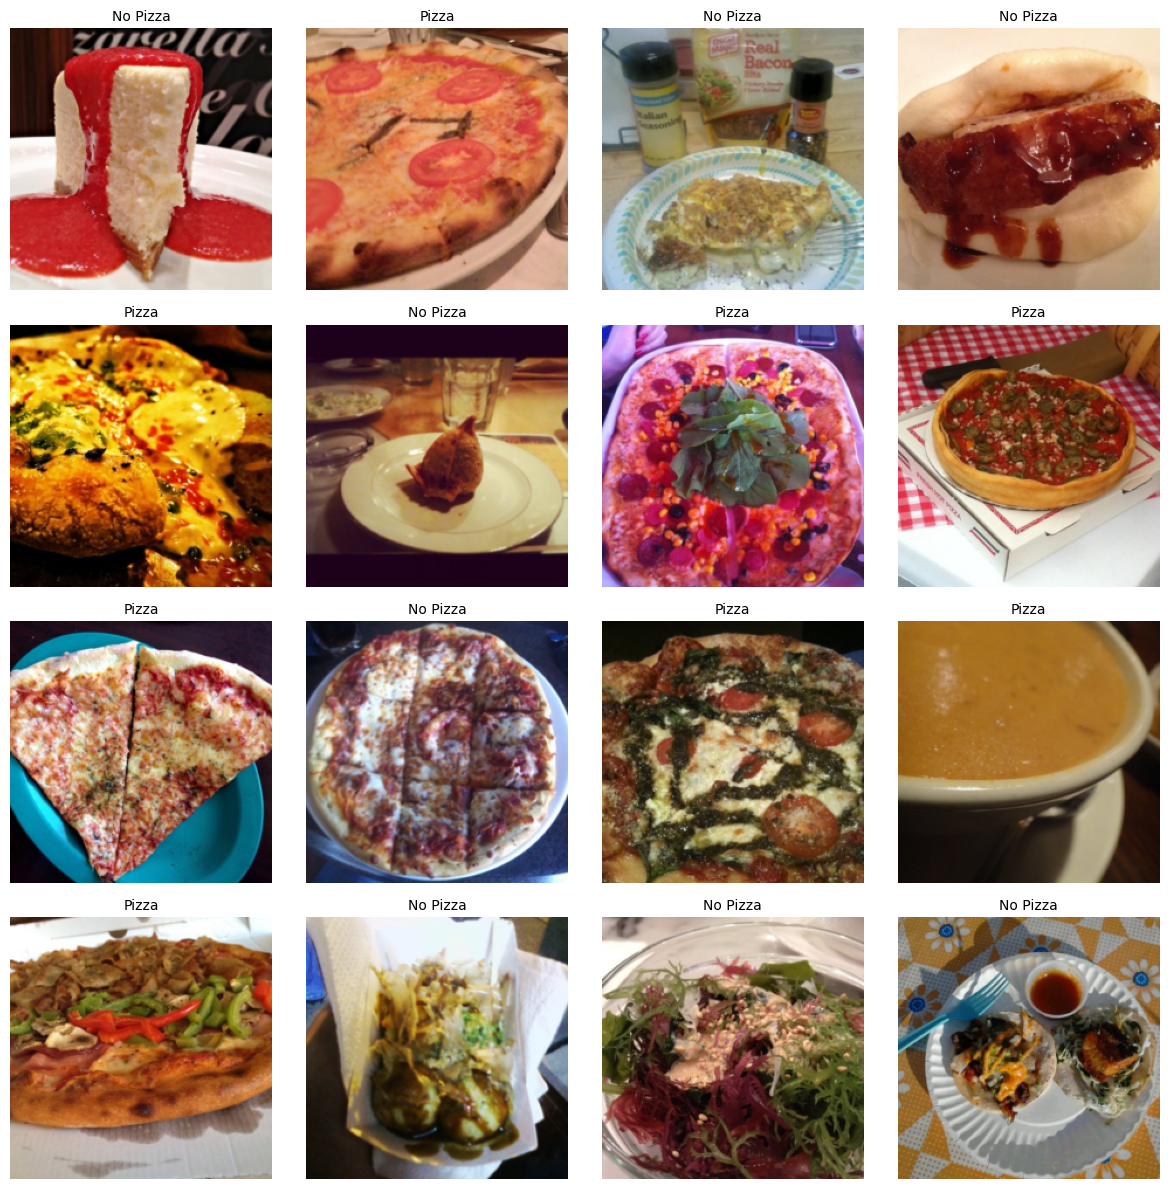

In [106]:
images_np = images.numpy()
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        index = i*4+j
        image = images_np[index]
        label = outputs_binary[index]
        axes[i, j].imshow(np.transpose(image, (1, 2, 0)))
        axes[i, j].set_title("Pizza" if label == 1 else "No Pizza", fontsize=10)
        axes[i, j].axis('off')  

plt.tight_layout()
plt.show()

Check Uni Mensa Stuttgart Pizza

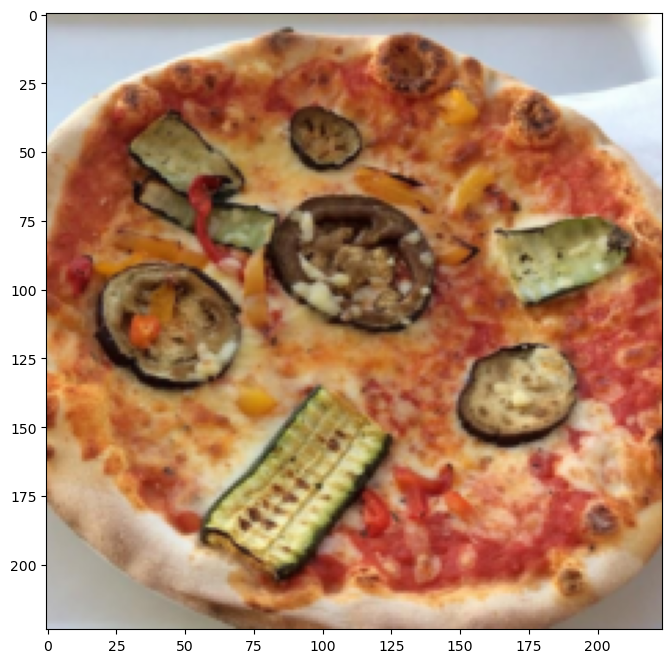

tensor([[0.9998]], grad_fn=<SigmoidBackward0>)
pizza


In [116]:
from PIL import Image

image_path = '../mensa_pizza.png' 
image = Image.open(image_path)
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

input_tensor = data_transform(image)
my_imshow(input_tensor)

input_tensor = input_tensor.unsqueeze(0)# Add batch dimension to match the model's input shape

output = cnn(input_tensor)
output_prob = torch.sigmoid(output)
print(output_prob)
output_binary = (output_prob > 0.5).squeeze().int()
threshold = 0.5
predicted_class = "pizza" if output_binary.item() >= threshold else "not pizza"
print(predicted_class)


Wuhuu! :D

## Final thoughts:

-add more complexity with transfer learning

-data augmentation has a huge impact to overfitting

-more computing power and iterations to test different parameters